In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
lowrankdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PNC/Top5/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
restmat = []
nbackmat = []
emoidmat = []
race = []
sex = []
age = []

a,b = np.triu_indices(264,1)

for sub in pncdemo['age_at_cnb']:
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{lowrankdir}/{sub}_task-resttop5_fc.npy')
        n = np.load(f'{lowrankdir}/{sub}_task-nbacktop5_fc.npy')
        e = np.load(f'{lowrankdir}/{sub}_task-emoidtop5_fc.npy')
        r = remap(vec2mat(r))
        n = remap(vec2mat(n))
        e = remap(vec2mat(e))
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r[a,b])
        nback.append(n[a,b])
        emoid.append(e[a,b])
        restmat.append(r)
        nbackmat.append(n)
        emoidmat.append(e)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
restmat = np.stack(restmat)
nbackmat = np.stack(nbackmat)
emoidmat = np.stack(emoidmat)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

print([a.shape for a in [rest, nback, emoid, restmat, nbackmat, emoidmat, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193, 264, 264), (1193, 264, 264), (1193, 264, 264), (1193,), (1193,), (1193,)]


In [246]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

class AE(nn.Module):
    def __init__(self, ld, rank):
        super(AE, self).__init__()
        self.rank = rank
        self.enc1 = nn.Linear(34716, ld).float().cuda()
        self.dec1 = nn.Linear(ld, rank*264).float().cuda()

    def enc(self, x):
        return self.enc1(x)

    def dec(self, x):
        y = self.dec1(x)
        y = y.reshape(x.shape[0], 264, self.rank)
        y = torch.einsum('nab,ncb->nac', y, y)
        return y

    def decvec(self, x):
        y = self.dec(x)
        a,b = np.triu_indices(264,1)
        y = y[:,a,b]
        return y

x = np.concatenate([rest, nback, emoid])
x = torch.from_numpy(x).float().cuda()

ae = AE(1000, 5)
optim = torch.optim.Adam(ae.parameters(), lr=1e-4, weight_decay=1e-4)

nepochs = 1000
pperiod = 20
bsize = 300

for e in range(nepochs):
    for b in range(0,len(x),bsize):
        optim.zero_grad()
        bx = x[b:b+bsize]
        by = ae.enc(bx)
        by = ae.decvec(by)
        loss = rmse(bx, by)
        loss.backward()
        optim.step()
        if e % pperiod == 0 or e == nepochs-1:
            print(f'{e} {float(loss)}')

print('Done')

0 0.3825018107891083
0 1.531625509262085
0 0.38841474056243896
0 0.5798879861831665
0 0.7185002565383911
0 0.5745782852172852
0 0.42446401715278625
0 0.34403640031814575
0 0.35037004947662354
0 0.31217214465141296
0 0.30426540970802307
0 0.30724823474884033
20 0.15968140959739685
20 0.15439896285533905
20 0.14873668551445007
20 0.15235447883605957
20 0.1360141932964325
20 0.13923944532871246
20 0.12858523428440094
20 0.13468897342681885
20 0.13998465240001678
20 0.13808795809745789
20 0.1357470005750656
20 0.13585078716278076
40 0.14766360819339752
40 0.14148615300655365
40 0.14125947654247284
40 0.1400011032819748
40 0.12501458823680878
40 0.12920638918876648
40 0.1196560487151146
40 0.1251021772623062
40 0.12673330307006836
40 0.13102856278419495
40 0.12673823535442352
40 0.12518204748630524
60 0.13658086955547333
60 0.13460522890090942
60 0.13385242223739624
60 0.13063713908195496
60 0.1206863597035408
60 0.1212201789021492
60 0.11538063734769821
60 0.11986026167869568
60 0.12114197

In [647]:
import random

class PhenoAE(nn.Module):
    def __init__(self, ld, nd):
        super(PhenoAE, self).__init__()
        self.nd = nd
        # Age, Male, Female, EA, AA
        self.enc1 = nn.Linear(5+nd, 50).float().cuda()
        self.enc2 = nn.Linear(50, ld).float().cuda()

    def forward(self, n, ag, m, f, aa, ea):
        y = torch.ones(n,1).float().cuda()
        x = torch.cat([ag*y, m*y, f*y, aa*y, ea*y], dim=1).float().cuda()
        xn = torch.normal(0, 1, size=(n, self.nd)).float().cuda()
        x = torch.cat([x, xn], dim=1)
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

age_tol = 2

def get_sim(age, sex, race, ag, m, aa):
    agsel = np.abs(age-ag) < age_tol
    msel = sex == m
    rsel = race == aa
    sel = agsel * msel * rsel
    return sel

def get_diff(age, sex, race, ag, m, aa):
    agsel = np.abs(age-ag) >= age_tol
    msel = sex != m
    rsel = race != aa
    sel = agsel * msel * rsel
    return sel

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

def rmse_loss(a, b):
    loss = 0
    for i in range(len(a)):
        aa = a[i:i+1].tile((len(b),1))
        err = torch.mean((aa-b)**2, dim=1)**0.5
        x = torch.exp(1/err)
        loss = loss + 1/torch.sum(x)
    return loss

def sim_loss(a):
    loss = 0
    for i in range(len(a)):
        for j in range(i+1, len(a)):
            val = rmse(a[i], a[j])
            loss += 1/val
    return loss/len(a)/(len(a)-1)*2

x = torch.from_numpy(rest).float().cuda()
with torch.no_grad():
    z = ae.enc(x)

nepochs = 2000
pperiod = 20

pae = PhenoAE(1000, 20)
optim = torch.optim.Adam(pae.parameters(), lr=1e-3, weight_decay=1e-4)

for e in range(nepochs):
    optim.zero_grad()
    ag = random.randint(8,20)
    m = random.randint(0,1)
    aa = random.randint(0,1)
    sel = np.where(get_sim(age, sex, race, ag, m, aa))[0]
    ztry = pae(5, ag, m, 1-m, aa, 1-aa)
    zztry = ae.decvec(ztry)
    with torch.no_grad():
        zsel = ae.decvec(z[sel]) 
    rloss = rmse_loss(zztry, zsel)
    sloss = 0.002*sim_loss(zztry)
    mloss = rmse(torch.mean(zztry, dim=0), torch.mean(zsel, dim=0))
    loss = rloss+sloss+mloss
    loss.backward()
    optim.step()
    with torch.no_grad():
        pae.enc1.weight[pae.enc1.weight > 0.1] = 0.1
        pae.enc1.weight[pae.enc1.weight < -0.1] = -0.1
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')

print('Done')

0 0.32154983282089233
20 0.3178845942020416
40 0.20792415738105774
60 0.16082045435905457
80 0.17385819554328918
100 0.15311290323734283
120 0.14532123506069183
140 0.0818493589758873
160 0.15470534563064575
180 0.13275879621505737
200 0.11563972383737564
220 0.12046220153570175
240 0.08719714730978012
260 0.11373323947191238
280 0.1510390341281891
300 0.08051849901676178
320 0.17111745476722717
340 0.08532710373401642
360 0.10751862823963165
380 0.10755012184381485
400 0.06897322088479996
420 0.07131025195121765
440 0.1466817855834961
460 0.07691299915313721
480 0.09610902518033981
500 0.1672075092792511
520 0.1583492010831833
540 0.09343647956848145
560 0.09289643168449402
580 0.08104601502418518
600 0.1781553328037262
620 0.07794634252786636
640 0.08993574976921082
660 0.1293467879295349
680 0.0974108949303627
700 0.0772310271859169
720 0.07105639576911926
740 0.07774180173873901
760 0.07413624227046967
780 0.10358185321092606
800 0.07415342330932617
820 0.10419708490371704
840 0.14

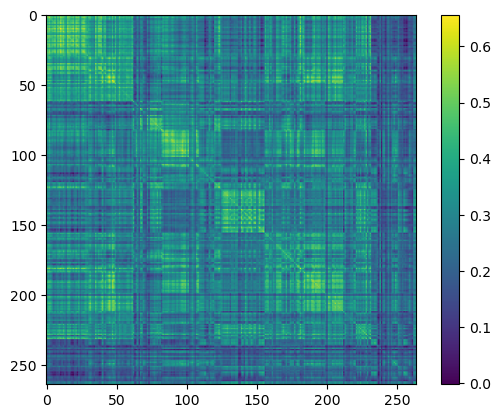

In [657]:
import matplotlib.pyplot as plt

with torch.no_grad():
    ag = random.randint(8,20)
    m = random.randint(0,1)
    aa = random.randint(0,1)
    ztry = pae(20, ag, m, 1-m, aa, 1-aa)
    res = ae.dec(ztry).detach().cpu().numpy()
    res = np.mean(res, axis=(0))
    # res[res > 1] = 1
    # res[res < -1] = -1

plt.imshow(res)
plt.colorbar()
plt.show()